# Test finding conserved quantities in Caloger-Moser model

In [1]:
import numpy as np
import tensorflow as tf
import sys
sys.path.append("../")
import os
import matplotlib.pyplot as plt
from IPython import display

from models import *
from hamiltonians import calogero_moser
from utils import make_train_op
from losses import make_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic
from utils import plot_traj, pull_back_traj


DTYPE=tf.float32
NP_DTYPE=np.float32


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.set_random_seed(0)

In [3]:
sess = tf.InteractiveSession()

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Settings

In [5]:
frequencies = [.1, .2, .3]
settings = {
    'hamiltonian': lambda x : calogero_moser(x, 'rational'),
    'd': 1,                    # space dimension
    'num_particles': 3,        # number of particles
    'minibatch_size': 2**7,    # Mini batch size
    'num_time_samples': 2**12, 
    'num_stacks_bijectors': 4, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/calogero-moser/",
    'ckpt_freq': 1000,
    'train_iters': 2,
    'visualize': True,
#    'grad_clip_norm': 1e-10, # clip norm to val. Comment for no gradient clipping
    'starter_learning_rate': 0.00001,    
    'decay_lr': "piecewise",
    'boundaries': [20000, 200000], # for piecewise decay
    'values': [1e-3, 1e-4, 1e-5],  # for piecewise decay
    'min_learning_rate': 1e-6,   
#     'decay_steps': 25000,  # ignored if decay_lr False
#     'decay_rate': 0.5,     # ignored if decay_lr False (decayed_learning_rate = learning_rate *
#                            #                            decay_rate ^ (global_step / decay_steps))
    'loss': "dKdphi",
    'base_dist': "action_dirac_angle",
#    'value_actions': [0.1324, 0.0312, 0.2925],
#    'elastic_net_coeff': 1.
    }
# Choose a batch of actions: needs to be divisor of dataset_size or minibatch_size if infinite dataset
# r = np.random.RandomState(seed=0)
# num_samples_actions = 2 # number of distinct actions (Liouville torii)
# sh = (num_samples_actions, settings['d'], settings['num_particles'], 1)
# settings['value_actions'] = r.rand(*sh).astype(NP_DTYPE)
# print(settings['value_actions'])

## Trajectories

In [ ]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=settings['num_time_samples'])

In [6]:
batch = 1
x0 = np.reshape([1,.1,2,.2,3,.3], (1, settings['d'], settings['num_particles'], 2)).astype(NP_DTYPE)
q0,p0 = extract_q_p(x0)
print("q0 = ", np.reshape(q0,[-1]))
print("p0 = ", np.reshape(p0,[-1]))
print("E  = ", sess.run( settings['hamiltonian'](x0) ))

q0 =  [1. 2. 3.]
p0 =  [0.1 0.2 0.3]
E  =  [9.319958]


In [7]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (num_time_samples,batch,d,n,2). Reinterpret batch and num_time_samples as batch
print(traj.shape)
qtraj, ptraj = extract_q_p( traj )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(128, 1, 1, 3, 2)


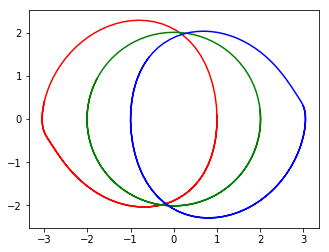

In [8]:
# orbits
plot_traj(settings, qtraj, ptraj)

## Define the model and loss

Define the model T as sequence of symplectic transformations 

In [9]:
# No oscillator flow, map directly to phat,qhat cartesian coords of action-angle
stack = []
for i in range(settings['num_stacks_bijectors']):
    stack.extend([#ZeroCenter(),
                  LinearSymplectic(householder_random_init=False),
#                  SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.tanh))])
                  SymplecticAdditiveCoupling(shift_model=IrrotationalMLP())])
T = Chain(stack)

Data, loss and train op:

In [11]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

# traj is (num_time_samples,batch,d,n,2)
dataset = tf.data.Dataset.from_tensor_slices(traj.astype(NP_DTYPE))
# repeat the dataset indefinetely
dataset = dataset.repeat()
# Shuffle data every epoch time (0th) dimension
dataset = dataset.shuffle(settings['num_time_samples'])
# Specify the minibatch size
dataset = dataset.batch(settings['minibatch_size'])
data_iterator = dataset.make_one_shot_iterator()
x = data_iterator.get_next()

#loss = make_loss(settings, T, x)
with tf.name_scope("canonical_transformation"):
    z = pull_back_traj(settings, T, x)
    loss = make_circle_loss(z) 

train_op = make_train_op(settings, loss, step)

## Train

In [12]:
sess.run(tf.global_variables_initializer())

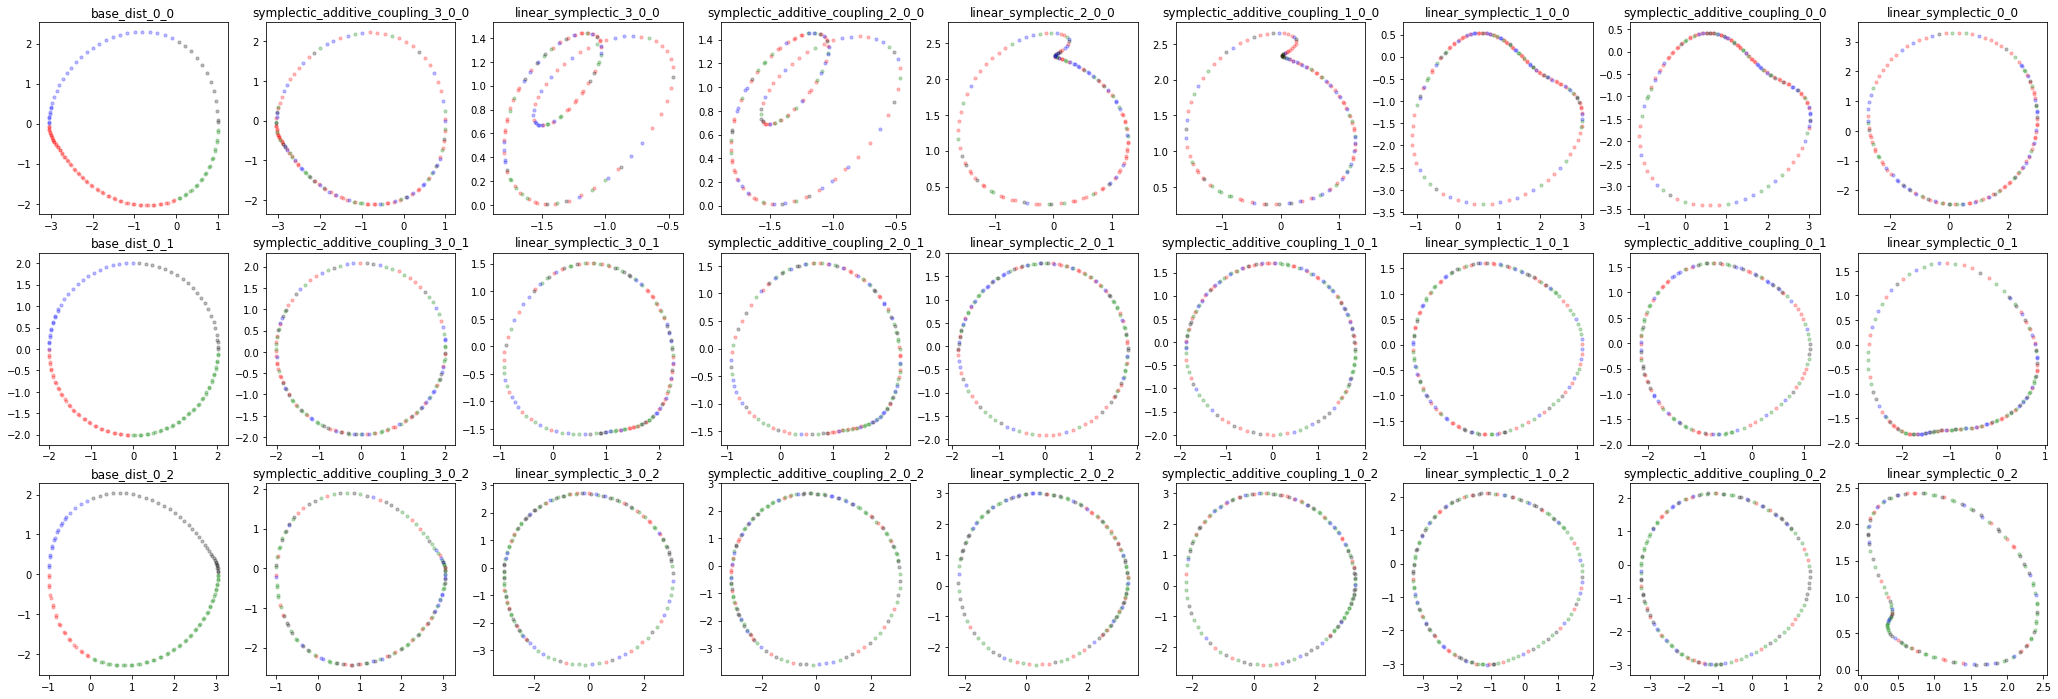

In [16]:
traj_to_show = tf.constant(traj[:,0,:,:,:], dtype=DTYPE)
visualize_chain_bijector(T, traj_to_show, sess=sess, inverse=True)

In [13]:
losses = []
# Coordinates to monitor
dd = 0; nn = 0
loss_np = 1 # Init
loss_converged = 5e-7

Loss at 33000 is 0.005494087003171444


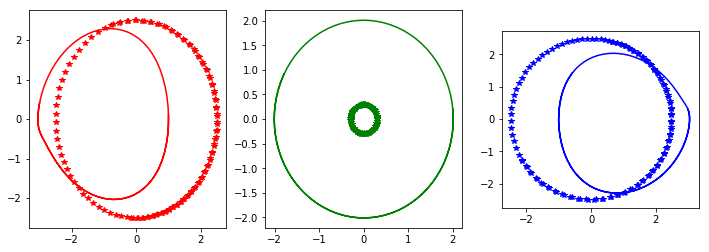

KeyboardInterrupt: 

In [14]:
while loss_np > loss_converged:
    _, it, loss_np = sess.run([train_op, step, loss])
    if it % 1000 == 0:        
        display.clear_output(wait=True)
        print("Loss at {} is {}".format(it, loss_np))
        
        qtraj_mini,ptraj_mini = sess.run(extract_q_p(x))
        qhat_traj_mini,phat_traj_mini = sess.run(extract_q_p(z))

        plot_traj(settings, qtraj_mini, ptraj_mini, qhat_traj_mini, phat_traj_mini)
        #plt.savefig('../results/kepler/image_at_it_{:04d}.png'.format(it))
        plt.show()   
    losses.append(loss_np)

In [9]:
# n = 2
# plt.plot(qtraj[:,0,n,0], ptraj[:,0,n,0], '-')
# plt.plot(qhat_traj[:,0,n,0], phat_traj[:,0,n,0], '*')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig('../results/CM_t2c.png')

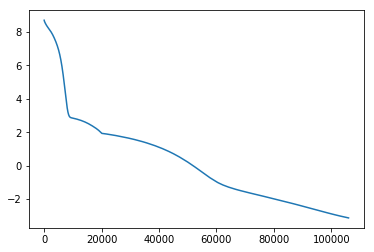

In [22]:
plt.plot(np.log(losses[:]))

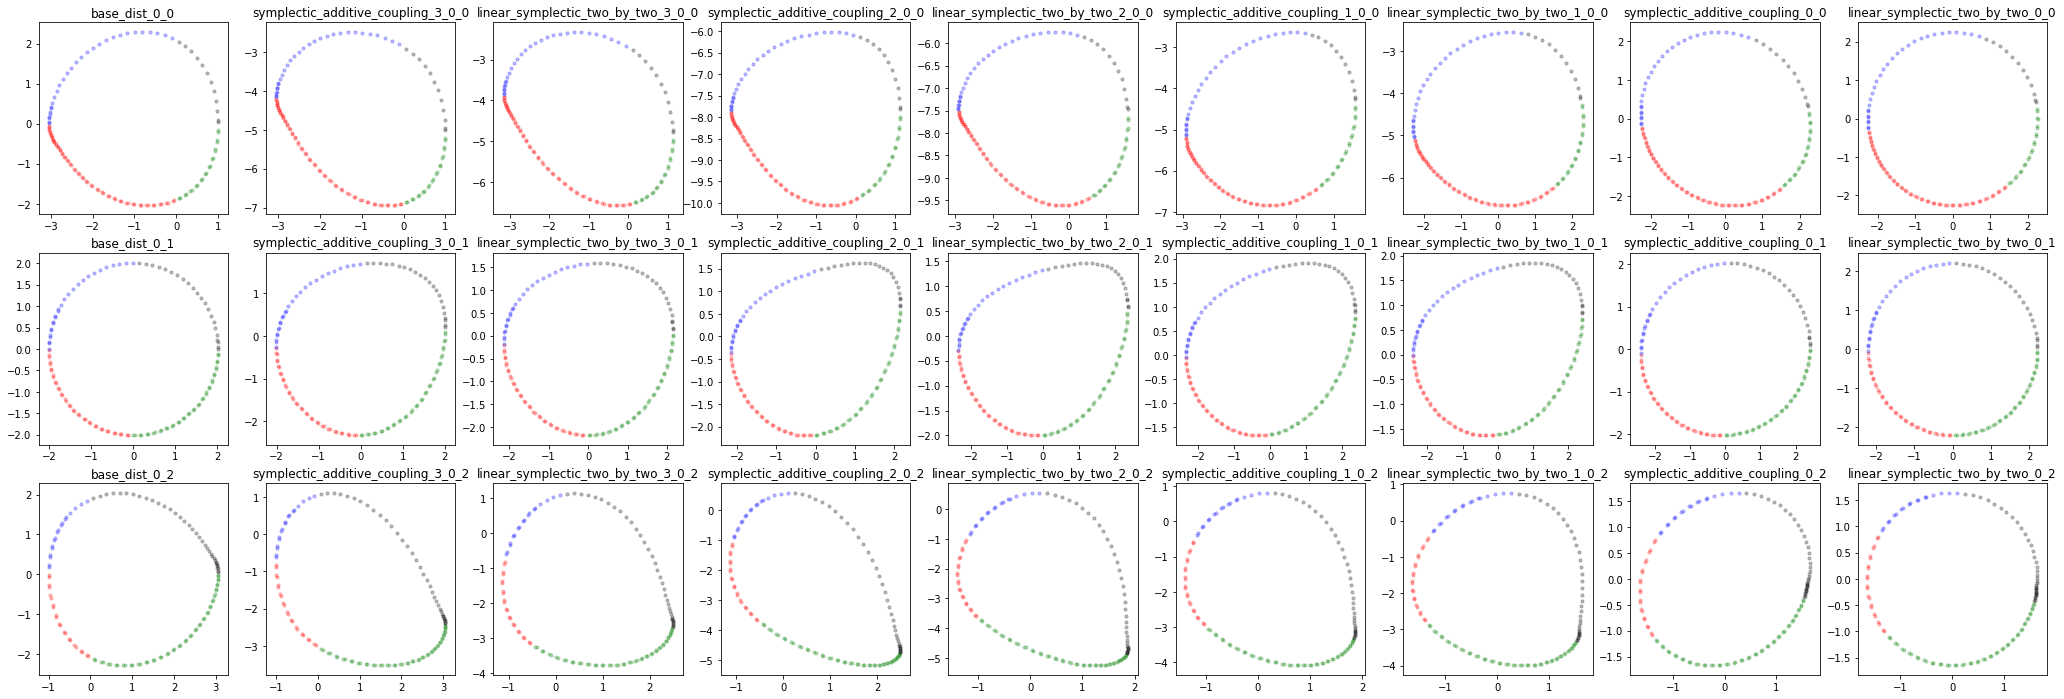

In [23]:
visualize_chain_bijector(T, traj, sess=sess, inverse=True)

In [ ]:
with tf.name_scope("canonical_transformation_train_full"):
    z = pull_back_traj(settings, T, x)
    loss = make_circle_loss(z) 
qhat_traj_full,phat_traj_full = sess.run(extract_q_p(z))
plot_traj(settings, qtraj, ptraj, qhat_traj_full, phat_traj_full)
print("Full train error: ", sess.run(loss))

## Test

In [ ]:
# Set the ZeroCenter bijectors to prediction mode:
for i, bijector in enumerate(T.bijectors):    
    if hasattr(bijector, 'is_training'):
        T.bijectors[i].is_training = False

In [ ]:
batch = 1
x0_test = np.reshape([1,.1,2,.2,3,.3], (1, settings['d'], settings['num_particles'], 2)).astype(NP_DTYPE)
q0,p0 = extract_q_p(x0)
print("q0 = ", np.reshape(q0,[-1]))
print("p0 = ", np.reshape(p0,[-1]))
print("E  = ", sess.run( settings['hamiltonian'](x0_test) ))

In [ ]:
traj_test = sess.run( integrator(x0_test, return_full_state=True) )
# traj has shape (num_time_samples,batch,d,n,2). Reinterpret batch and num_time_samples as batch
print(traj_test.shape)
qtraj_test, ptraj_test = extract_q_p( traj_test )

In [ ]:
# orbits
plot_traj(settings, qtraj_test, ptraj_test)

In [ ]:
with tf.name_scope("canonical_transformation_test"):
    z_test = pull_back_traj(settings, T, traj_test)
    loss_test = make_circle_loss(z) 
qhat_traj_test,phat_traj_test = sess.run(extract_q_p(z_test))
plot_traj(settings, qtraj_test, ptraj_test, qhat_traj_test, phat_traj_test)
print("Test error: ", sess.run(loss_test))

In [ ]:
traj_to_show = tf.constant(traj_test[:,0,:,:,:], dtype=DTYPE)
visualize_chain_bijector(T, traj_to_show, sess=sess, inverse=True)